<h1 align=center><font size = 10> k-Means </font></h1>

In this notebook, we try to practice one of the most popular algorithms in Clustering that we learned in this course: k-Means algorithm. 

We load a dataset using Pandas library and apply k-Means to explore information from data.
Lets first load required libraries:

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot') # Look Pretty

def showandtell(title=None):
  plt.show()

A convenience function for you to use:

In [2]:
def clusterInfo(model):
    print("Cluster Analysis Inertia: ", model.inertia_)
    print('------------------------------------------')
    
    for i in range(len(model.cluster_centers_)):
        print("\n  Cluster ", i)
        print("    Centroid ", model.cluster_centers_[i])
        print("    #Samples ", (model.labels_==i).sum()) # NumPy Power

In [3]:
# Find the cluster with the least # attached nodes
def clusterWithFewestSamples(model):
    # Ensure there's at least on cluster...
    minSamples = len(model.labels_)
    minCluster = 0
    
    for i in range(len(model.cluster_centers_)):
        if minSamples > (model.labels_==i).sum():
            minCluster = i
            minSamples = (model.labels_==i).sum()

    print("\n  Cluster With Fewest Samples: ", minCluster)
    return (model.labels_==minCluster)

# Mandatory part (85%  of the total score)

### About dataset

A [call detail record](https://en.wikipedia.org/wiki/Call_detail_record) (CDR) is a data record produced by a telephone exchange or other telecommunications equipment that documents the details of a telephone call or other telecommunications transaction (e.g., text message) that passes through that facility or device.

The questions you'll be exploring in this lab assignment using K-Means are: exactly how useful is telephone metadata? It must have some use, otherwise, the government wouldn't have invested however many millions they did into it secretly collecting it from phone carriers. Also what kind of intelligence can you extract from CDR metadata besides its face value?

The record contains various attributes of the call, such as time, duration, completion status, source number, and destination number. It is the automated equivalent of the paper toll tickets that were written and timed by operators for long-distance calls in a manual telephone exchange.

The dataset we've curated for you contains call records of 10 people, tracked over the course of 3 years. Your job in this assignment is to find out where each of these people likely live and where they work at!


**1. Start by loading up the dataset and taking a peek at its head. You have to convert date-strings to real date-time objects using `pd.to_datetime`, and the times using `pd.to_timedelta`:**

In [4]:
df = pd.read_csv("CDR.csv")
df.tail()

,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
53183,8549533077,491169353,Missed,2013-02-26,19:11:18.125445,Tue,0:04:05.656331,6c1f0271-70e2-4ea6-bb8b-23b3b0b06117,32.772361,-96.777278
53184,8549533077,2362231379,Incoming,2013-02-26,18:01:56.075434,Tue,0:01:53.848597,a11a02cf-73c6-479c-8cf1-8fbee7917716,32.786556,-96.791250
53185,8549533077,186272563,Incoming,2013-02-26,16:08:57.602134,Tue,0:01:57.577549,06fe2702-1f88-4dfd-90d6-22c2d3227855,32.985083,-96.802556
53186,8549533077,2288700880,Incoming,2013-02-26,08:01:39.721347,Tue,0:01:39.690498,269b1e26-49c4-4308-8879-8f2d37528c8a,32.985083,-96.802528
53187,8549533077,491169353,Incoming,2013-02-26,10:47:00.637845,Tue,0:03:42.595246,269b1e26-49c4-4308-8879-8f2d37528c8a,32.985083,-96.802528


In [5]:
df.shape

(53188, 10)

In [6]:
df.dtypes

In             int64
Out            int64
Direction     object
CallDate      object
CallTime      object
DOW           object
Duration      object
TowerID       object
TowerLat     float64
TowerLon     float64
dtype: object

In [7]:
df['CallDate']= pd.to_datetime(df['CallDate'])
df['CallTime']= pd.to_datetime(df['CallTime'])
df['Duration']= pd.to_timedelta(df['Duration'])

**2. Create a distinct list of `In` phone numbers (people) and store the values in a regular python list.**

Make sure the numbers appear in your list in the same order they appear in your dataframe; but only keep a single copy of each number. [This link](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html) might also be helpful.

In [8]:
In_list = df['In'].unique().tolist()
In_list

[4638472273,
 1559410755,
 4931532174,
 2419930464,
 1884182865,
 3688089071,
 4555003213,
 2068627935,
 2894365987,
 8549533077]

**3. Create a slice named `user1` that filters to _only_ include dataset records where the `In` feature (user's phone number) is equal to the first number on your unique list above, i.e., the very first number in the dataset:**

In [9]:
user1 = df[df['In'] == In_list[0]]
user1

,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
0,4638472273,2666307251,Incoming,2010-12-25,2020-06-24 07:16:24.736813,Sat,00:02:41.741499,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417
1,4638472273,1755442610,Incoming,2010-12-25,2020-06-24 21:18:30.053710,Sat,00:02:47.108750,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500
2,4638472273,5481755331,Incoming,2010-12-25,2020-06-24 14:52:42.878016,Sat,00:04:35.356341,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
3,4638472273,1755442610,Incoming,2010-12-25,2020-06-24 16:02:09.001913,Sat,00:02:23.498499,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
4,4638472273,2145623768,Incoming,2010-12-25,2020-06-24 15:28:35.028554,Sat,00:03:54.692497,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389
...,...,...,...,...,...,...,...,...,...,...
53140,4638472273,2666307251,Missed,2013-02-26,2020-06-24 11:26:01.888502,Tue,00:03:08.177065,0296279d-18c3-4709-853e-3e20496ce444,32.899944,-96.910389
53141,4638472273,2145623768,Missed,2013-02-26,2020-06-24 17:32:18.776276,Tue,00:02:30.823459,78512965-e30b-4734-ae92-47b910fe3d7f,32.899944,-96.910389
53142,4638472273,4551601645,Incoming,2013-02-26,2020-06-24 19:12:44.730636,Tue,00:03:42.954201,8fb02570-fb3f-4381-be74-3e1accf87ec5,32.750556,-96.694722
53143,4638472273,7721472178,Incoming,2013-02-26,2020-06-24 07:50:41.435642,Tue,00:04:04.460385,e78826ad-45b0-45d4-90ec-4776d73f1d8e,32.864167,-96.836944


**4. Let's go ahead and plot all the call locations for user 1 in all time:**


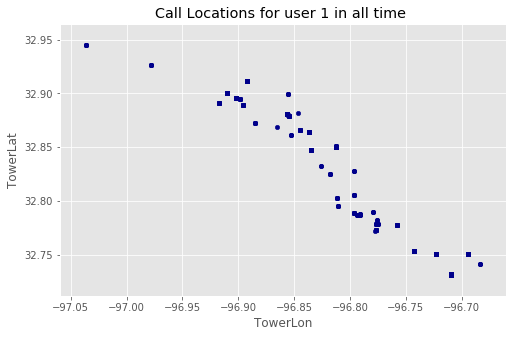

In [10]:
user1.plot(kind = 'scatter', x = 'TowerLon', y ='TowerLat', figsize= (8,5), color = 'darkblue')
plt.title("Call Locations for user 1 in all time ")
plt.xlabel("TowerLon")
plt.ylabel("TowerLat")
plt.show()

INFO: The locations map above should be too "busy" to really wrap your head around. This is where domain expertise comes into play. Your intuition can direct you by knowing people are likely to behave differently on weekends vs on weekdays:

#### On Weekends
1. People probably don't go into work
1. They probably sleep in late on Saturday
1. They probably run a bunch of random errands, since they couldn't during the week
1. They should be home, at least during the very late hours, e.g. 1-4 AM

#### On Weekdays
1. People probably are at work during normal working hours
1. They probably are at home in the early morning and during the late night
1. They probably spend time commuting between work and home everyday

**5. Add more filters to the `user1` slice you created. Add bitwise logic so that you only examine records that _came in_ on weekends (sat/sun):**

In [11]:
user1_1 = user1[(user1['DOW'] =='Sat') | (user1['DOW'] =='Sun')]
user1_1

,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
0,4638472273,2666307251,Incoming,2010-12-25,2020-06-24 07:16:24.736813,Sat,00:02:41.741499,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417
1,4638472273,1755442610,Incoming,2010-12-25,2020-06-24 21:18:30.053710,Sat,00:02:47.108750,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500
2,4638472273,5481755331,Incoming,2010-12-25,2020-06-24 14:52:42.878016,Sat,00:04:35.356341,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
3,4638472273,1755442610,Incoming,2010-12-25,2020-06-24 16:02:09.001913,Sat,00:02:23.498499,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
4,4638472273,2145623768,Incoming,2010-12-25,2020-06-24 15:28:35.028554,Sat,00:03:54.692497,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389
...,...,...,...,...,...,...,...,...,...,...
52964,4638472273,6022767590,Incoming,2013-02-23,2020-06-24 16:12:12.701600,Sat,00:02:21.278138,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
52965,4638472273,5621270003,Incoming,2013-02-23,2020-06-24 09:11:21.606945,Sat,00:03:19.757526,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
53022,4638472273,7756914135,Incoming,2013-02-24,2020-06-24 16:49:42.830258,Sun,00:02:19.285474,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
53023,4638472273,7721472178,Incoming,2013-02-24,2020-06-24 10:32:55.146952,Sun,00:00:04.908620,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389


**6. Further filter `user1` down for calls that came in either before 6am OR after 10pm (22:00:00).**

Even if you didn't convert your times from string objects to time deltas, you can still use `<` and `>` to compare the string times as long as you code them as [military time strings](https://en.wikipedia.org/wiki/24-hour_clock), eg: "06:00:00", "22:00:00": 

You may also want to review the Data Manipulation section for this. Once you have your filtered slice, print out its length:

In [12]:
user1_2 = user1_1[(user1_1['CallTime']< '06:00:00') | (user1_1['CallTime'] > '22:00:00')]
user1_2.head()

,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
940,4638472273,6150928001,Incoming,2011-01-08,2020-06-24 22:22:33.693878,Sat,00:00:35.065912,26f7441e-e64b-4b9d-8c5a-0eb34f7e919f,32.731611,-96.709417
1875,4638472273,2145623768,Incoming,2011-01-22,2020-06-24 22:21:27.466908,Sat,00:03:40.018320,2567c73b-3711-4a31-8683-9d12d56857d8,32.731611,-96.709417
6949,4638472273,5621270003,Missed,2011-04-09,2020-06-24 22:59:23.206408,Sat,00:03:06.567364,2567c73b-3711-4a31-8683-9d12d56857d8,32.731611,-96.709417
7468,4638472273,7756914135,Incoming,2011-04-17,2020-06-24 05:15:40.205917,Sun,00:02:09.984993,cd9f3b1a-2eb8-4cdb-86d1-5d4c2740b1dc,32.731722,-96.709500
9753,4638472273,7922223441,Incoming,2011-05-21,2020-06-24 05:08:20.121145,Sat,00:01:30.059591,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417


**7. Visualize the dataframe with a scatter plot as a sanity check.**

Since you're [familiar with maps](https://en.wikipedia.org/wiki/Geographic_coordinate_system#Geographic_latitude_and_longitude), you know well that your X-Coordinate should be Longitude, and your Y coordinate should be the tower Latitude. Check the dataset headers for proper column feature names.
 
At this point, you don't yet know exactly where the user is located just based on the cell phone tower position data; but considering the below are for Calls that arrived in the twilight hours of weekends, it's likely that wherever they are bunched up is probably near where the caller's residence:

Text(0.5, 1.0, 'Weekend Calls (< 6am or > 10pm) for user 1')

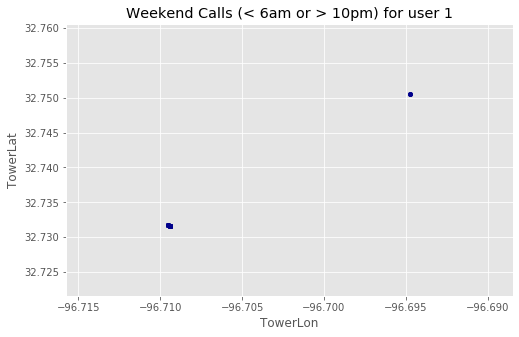

In [13]:
user1_2.plot(kind = 'scatter', x = 'TowerLon', y = 'TowerLat', figsize=(8,5), color = 'darkblue')
plt.title("Weekend Calls (< 6am or > 10pm) for user 1")

**8. Run K-Means on that dataframe with `K=2` then print out the Cluster Info using clusterInfo function**, with the goal being that one of the centroids will sweep up the annoying outliers; and the other will zero in on the user's approximate home location. Or rather the location of the cell tower closest to their home.....

Be sure to only feed in Lat and Lon coordinates to the KMeans algorithm since none of the other data is suitable for your purposes. Since both Lat and Lon are (approximately) on the same scale, no feature scaling is required.

In [14]:
from sklearn.cluster import KMeans

In [15]:
X = user1_2[['TowerLat','TowerLon']]

In [16]:
k_means = KMeans(init = 'k-means++', n_clusters = 2, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
labels

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0])

In [17]:
clusterInfo(k_means)

Cluster Analysis Inertia:  1.1304346153788864e-07
------------------------------------------

  Cluster  0
    Centroid  [ 32.73164942 -96.70944573]
    #Samples  26

  Cluster  1
    Centroid  [ 32.750556 -96.694722]
    #Samples  2


**9. Add centroid locations onto your scatter plot. Use a distinguishable marker and color.**

Hint: Make sure you graph the CORRECT coordinates. This is part of your domain expertise.

In [18]:
X_center = k_means.cluster_centers_
X_center

array([[ 32.73164942, -96.70944573],
       [ 32.750556  , -96.694722  ]])

Text(0.5, 1.0, 'Weekend Calls ( <6am or > 10p) for user 1')

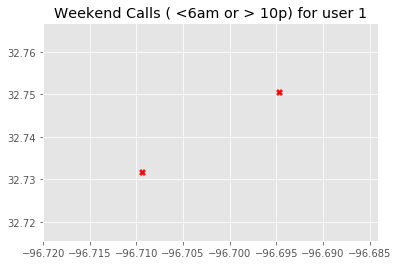

In [19]:
plt.scatter(X_center[:,1], X_center[:,0] , marker='X', color = 'r') 
plt.title("Weekend Calls ( <6am or > 10p) for user 1")

**10. Now that you have a system in place, repeat the above steps (4, 8, and 9) for all 10 individuals in the dataset**. 

You might want to use a for-loop unless you enjoy copying and pasting:

In [20]:
models = []
for x in range (len(In_list)):
    userX = df[df['In'] == In_list[x]]
    userX_1 = userX[(userX['DOW'] =='Sat') | (userX['DOW'] =='Sun')]
    userX_2 = userX_1[(userX_1['CallTime']< '06:00:00') | (userX_1['CallTime'] > '22:00:00')]
    X1 = userX_2[['TowerLat','TowerLon']]
    k_meansX = KMeans(init = 'k-means++', n_clusters = 2, n_init = 12)
    k_meansX.fit(X1)
    models.append(k_meansX)
    
clusterInfo(models[2])


Cluster Analysis Inertia:  1.9522045272845406e-05
------------------------------------------

  Cluster  0
    Centroid  [ 32.86592718 -96.865298  ]
    #Samples  22

  Cluster  1
    Centroid  [ 32.857778 -96.864444]
    #Samples  1


C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:8: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  
C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:8: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  


**11. Alter your slice from user1, so that it includes only Weekday (Mon-Fri) values and before 5pm:**

The idea is that the call was placed before 5pm. From Midnight-730a, the user is probably sleeping and won't call/wake up to take a call. There should be a brief time in the morning during their commute to work, then they'll spend the entire day at work. So the assumption is that most of the time is spent either at work or at the second, at home:
        

In [21]:
user1_weekdays_daytime = user1[(user1['DOW']!='Sat') & (user1['DOW']!='Sun')]
user1_weekdays_daytime = user1_weekdays_daytime[(user1_weekdays_daytime['CallTime']< '17:00:00')]
user1_weekdays_daytime.shape

(1405, 10)

**12. Plot the Cell Towers the above data frame:**


Text(0.5, 1.0, 'Call Locations for user 1 in working daytimes')

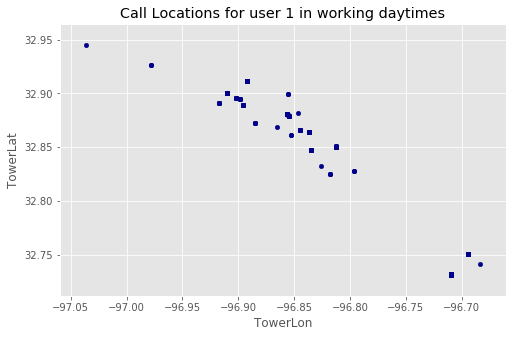

In [22]:
user1_weekdays_daytime.plot(kind = 'scatter', x = 'TowerLon', y = 'TowerLat', figsize = (8,5), color ='darkblue')
plt.title("Call Locations for user 1 in working daytimes")

**13. Complete the doKmeans function:**

In [23]:
def doKMeans(data, num_clusters=0):
    model = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 12)
    model.fit(data)
    return model

In [24]:
Y = user1_weekdays_daytime[['TowerLat','TowerLon']]

**14. Let's tun K-Means with `K=3`using doKMeans function for that dataframe (user1 on weekdays in daytime). Then print out the cluster info using clusterInfo function:**

There should only be two areas of concentration. If you notice multiple areas that are "hot" (multiple areas the user spends a lot of time at that are FAR apart from one another).

In [25]:
k_means3 = doKMeans(Y,3)

In [26]:
labels3 = k_means3.labels_
clusterInfo(k_means3)

Cluster Analysis Inertia:  0.15891069523780382
------------------------------------------

  Cluster  0
    Centroid  [ 32.9000009  -96.90951639]
    #Samples  959

  Cluster  1
    Centroid  [ 32.73323174 -96.70816184]
    #Samples  306

  Cluster  2
    Centroid  [ 32.86348712 -96.83818346]
    #Samples  140


**15. Print out the mean `CallTime` value for the samples belonging to the cluster with the LEAST samples attached to it.** 

If our logic is correct, the cluster with the MOST samples will be work. The cluster with the 2nd most samples will be home. And the `K=3` cluster with the least samples should be somewhere in between the two. What time, on average, is the user in between home and work, between midnight and 5pm?

In [27]:
import numpy as np
Y1 = Y.copy()
Y1['CallTime']= user1_weekdays_daytime['CallTime']
Y1['Label'] = labels3
Y1['Duration']= user1_weekdays_daytime['Duration']
Y1['Duration']= pd.to_timedelta(Y1['Duration'])

In [30]:
Y1

,TowerLat,TowerLon,CallTime,Label,Duration
197,32.899944,-96.910389,2020-06-24 16:20:11.532130,0,00:03:56.069765
200,32.899944,-96.910389,2020-06-24 15:27:51.105337,0,00:03:30.047757
248,32.899944,-96.910389,2020-06-24 09:13:35.198987,0,00:02:10.574446
249,32.731611,-96.709417,2020-06-24 06:02:11.319738,1,00:04:34.436752
250,32.899944,-96.910389,2020-06-24 13:54:14.724722,0,00:03:31.297111
...,...,...,...,...,...
53091,32.899944,-96.910389,2020-06-24 16:55:01.129212,0,00:02:48.163010
53138,32.731722,-96.709500,2020-06-24 07:28:38.486982,1,00:03:51.307727
53140,32.899944,-96.910389,2020-06-24 11:26:01.888502,0,00:03:08.177065
53143,32.864167,-96.836944,2020-06-24 07:50:41.435642,2,00:04:04.460385


In [31]:
# tim ra cluster co so samples nho nhat
# tao mot dictionary Samples, roi tinh tong cac sample trong 1 cluster, add vao dic
Samples = {}
for i in range(len(k_means3.cluster_centers_)):
    S = (k_means3.labels_==i).sum()
    Samples[i] = S
# sample min
sam_min = min(Samples.values())
# cluster min
clu_min = list(Samples.keys())[list(Samples.values()).index(sam_min)]
print('Cluster With Fewest Samples: ', clu_min)
# tinh tong duration cua cluster min
Y2 = Y1[Y1['Label'] == clu_min]
dura_min = Y2['Duration'].sum()
print('Its Waypoint Time: ', dura_min)

Cluster With Fewest Samples:  2
Its Waypoint Time:  0 days 07:36:37.580587


In [32]:
a = sorted(Samples.items(), key=lambda x: x[1])    
print(a)

[(2, 140), (1, 306), (0, 959)]


In [33]:
a[0][1]

140

In [34]:
Y2 = Y1[Y1['Label'] == clu_min]
Y2['Duration'].sum()

Timedelta('0 days 07:36:37.580587')

**16. Let's visualize the results by drawing the X's for the cluster centers combined with location plot:**


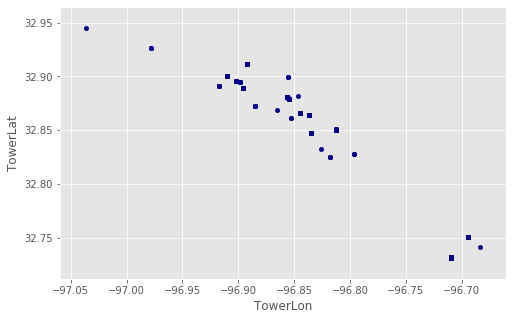

In [35]:
Y1.plot(kind ='scatter', x='TowerLon', y= 'TowerLat', figsize =(8,5), color = 'darkblue')


In [36]:
cluster_center = k_means3.cluster_centers_
cluster_center

array([[ 32.9000009 , -96.90951639],
       [ 32.73323174, -96.70816184],
       [ 32.86348712, -96.83818346]])

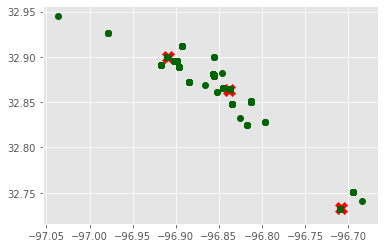

In [37]:
plt.plot(Y1['TowerLon'], Y1['TowerLat'], color= 'darkgreen', marker='o',ls='None')
plt.scatter(cluster_center[:,1], cluster_center[:,0],  marker="X", color='r', s=150)

# Adanved part (15%  of the total score)

**17. Now that you have a system in place, repeat the the steps 12, 14 and 16 for all 10 individuals in the dataset.**

Cluster Analysis Inertia:  0.24673904238447752
------------------------------------------

  Cluster  0
    Centroid  [ 32.72097347 -96.83039184]
    #Samples  1648

  Cluster  1
    Centroid  [ 32.703056 -96.604444]
    #Samples  392

  Cluster  2
    Centroid  [ 32.71410598 -96.75520357]
    #Samples  254


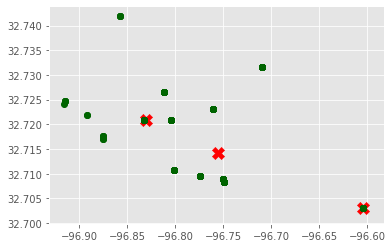

In [38]:
modelsY = []
Y_data = []
cluster_centerY = 0
for y in range (len(In_list)):
    userY = df[df['In'] == In_list[y]]
    userY_weekdays_daytime = userY[(userY['DOW']!='Sat') & (userY['DOW']!='Sun')]
    userY_weekdays_daytime = userY_weekdays_daytime[(userY_weekdays_daytime['CallTime']< '17:00:00')]
    Y_1 = userY_weekdays_daytime[['TowerLat','TowerLon']]
    Y_data.append(Y_1)
    k_meansY = KMeans(init = 'k-means++', n_clusters = 3, n_init = 12)
    k_meansY.fit(Y_1)
    modelsY.append(k_meansY)
n = 7
Y_2 = Y_data[n]    
m = modelsY[n]
labelsY = m.labels_
cluster_centerY = m.cluster_centers_
clusterInfo(m)
plt.plot(Y_2['TowerLon'], Y_2['TowerLat'], color= 'darkgreen', marker='o',ls='None')
plt.scatter(cluster_centerY[:,1], cluster_centerY[:,0],  marker="X", color='r', s=150)

In [39]:
Y_2

,TowerLat,TowerLon
182,32.720833,-96.832222
183,32.720833,-96.832222
184,32.720833,-96.832222
185,32.708333,-96.749167
270,32.720833,-96.832222
...,...,...
53155,32.720833,-96.832222
53156,32.723056,-96.760583
53158,32.720833,-96.832222
53159,32.726556,-96.811472
